In this notebook, we perform the preprocessing of the dataset "data-science-bootcamp/content/datasets/classification/raw/classification_25.csv". 
The output of this notebook will be written in the folder "data-science-bootcamp/content/datasets/classification/processed" as four separated csv files: X_train.csv, X_test.csv, y_train.csv, y_test.csv. (These files will be used as input for the ML algorithms which are discussed in the next sessions of the bootcamp).

The dataset is a modified version of "default_of_credit_card_clients.xls" from https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients. The slight modifications are done for the pedagogical reasons of demonstrating different methods of preprocessing and feature engineering (particularly, missing value imputation and categorical encoding).
This binary classification dataset contains 23 different attributes of the customers and 1 binary column "default payment next month" which is the target column to be predicted by the ML model. 

The notebook contains the following sections:

0. Exploratory Data Analysis
1. Missing Value Imputation
1.0. Identifying columns with null values \
1.1. Complete Case Analysis\
1.2. Mean or Median Imputation \
1.3. Frequent Category Imputation (Mode Imputation)
2. Categorical encoding\
2.1. One Hot Encoding 
3. Handling Outliers\
3.1. Identifying the outliers \
3.2. Outlier trimming \
3.3. Outlier Capping
4. Feature Scaling\
4.1. Min-Max Scaling
5. Feature Selection\
5.1. Dropping Constant Features \
5.2. Correlation-based Feature Selection\
5.2.a Selecting Features with hight correlations with Target\
5.2.a Selecting Features with low correlations with other features
6. Finalizing\
6.1. Saving the preprocessed data\
6.2. Testing the cleaned data with feeding it to a logistic regression algorithm



# 0. Exploratory Data Analysis

In [1]:
#importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
pd.set_option('display.max_columns', None) 
import warnings
warnings.filterwarnings('ignore')

### 0.1 Loading the data into a dataframe

In [2]:
# loading the "data_25.csv" into a dataframe called "df"
df= pd.read_csv('../datasets/classification/raw/classification_25.csv', sep= ";", encoding= "utf-8")

In [3]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,female,university,married,24.0,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,female,university,single,26.0,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,female,university,single,34.0,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,female,university,married,37.0,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,male,university,married,57.0,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [4]:
# drop the first column ("ID")
df.drop(columns=["ID"], axis=1, inplace= True)

In [5]:
# check the shape of the dataframe as a 2-dimensional data object (#rows, #columns)
df.shape

(30000, 24)

The dataset contains 30000 records (rows) and 24 columns (features + target):

The target column (y) is called target.
The rest 23 columns (X) are our feature vectors.

In [6]:
# storing the "default payment next month" in a variable called "target", and the rest of columns' names in a variable called "X"
target = "default payment next month"
X = list(set(df.columns) - set([target])) 

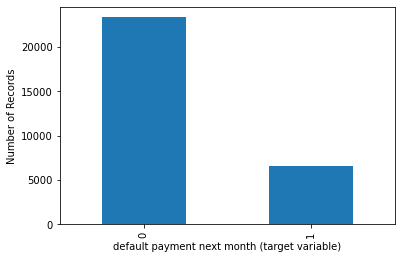

In [7]:
df[target].value_counts().plot(kind="bar")
plt.ylabel("Number of Records")
plt.xlabel("default payment next month (target variable)")
plt.show()

In [8]:
# calculate the imbalance ration of the target classes
class_0 = df[target].value_counts().to_list()[0]
class_1 = df[target].value_counts().to_list()[1]
original_imbalance_ratio = class_1/class_0
print("Imbalance ratio =", original_imbalance_ratio)

Imbalance ratio = 0.2840267077555213


The imbalance ratio is 0.28 which is good enough for this classification problem, given the size of the dataset (30000).\
we will later compare the original_imbalance_ratio with the train_imbalance_ration which is obtained after train/test split and demand that they are not very different.

In [9]:
# We first have a look at the data types of all columns
df_type = pd.DataFrame(df.dtypes)
df_type

,0
LIMIT_BAL,int64
SEX,object
EDUCATION,object
MARRIAGE,object
AGE,float64
PAY_0,int64
PAY_2,int64
PAY_3,int64
PAY_4,int64
PAY_5,int64


In [10]:
# classifying feature columns with different data types:
str_cols = []
for col, dtype in df[X].dtypes.to_dict().items():
    if str(dtype) in 'object':
        str_cols.append(col)

print("Number of String Columns:", len(str_cols))

num_cols = []
for col, dtype in df[X].dtypes.to_dict().items():
    if str(dtype) in 'int64' or str(dtype) in 'float64':
        num_cols.append(col)
print("Number of numerical Columns:", len(num_cols))

Number of String Columns: 3
Number of numerical Columns: 20


# 1. Missing Value Imputation

### 1.0. Identifying columns with null values

In [11]:
# creating a list of columns which contain missing values
null_cols = [col for col in df.columns if df[col].isnull().mean() > 0] 

In [12]:
print(null_cols)

['EDUCATION', 'MARRIAGE', 'AGE']


In [13]:
print("Number of Columns with Null values:", len(null_cols))
print("Percentage of null values:")
for col in null_cols:
    print(col, round(df[col].isnull().mean(), 4), ", Data Type: ", df[col].dtype)

Number of Columns with Null values: 3
Percentage of null values:
EDUCATION 0.0115 , Data Type:  object
MARRIAGE 0.0018 , Data Type:  object
AGE 0.0187 , Data Type:  float64


We observe that "EDUCATION" and "AGE" have less than 2% missing values and "MARRIAGE" has 0.18% missing value.\
For the column "MARRIAGE", we perform Complete Case Analysis,\
For the integer column "AGE", we perform mean/median imputation, \
For the categorical column "EDUCATION", we perform Frequent Category Imputation.

### 1.1. Complete Case Analysis

In [14]:
df = df.dropna(subset=["MARRIAGE"],  axis=0) 
df.shape

(29946, 24)

We observe that after dropping the missing values, the number of records is reduced from 30000 to 29946.

### 1.2. Mean or Median Imputation

Before filling the null values, we split the data into train and test sets

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df[X], df[target], test_size=0.3, random_state=10)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((20962, 23), (8984, 23), (20962,), (8984,))

In [16]:
y_train_class_0 = y_train.value_counts().to_list()[0]
y_train_class_1 = y_train.value_counts().to_list()[1]
train_imbalance_ration = y_train_class_1/y_train_class_0
print("Original imbalance ratio =", original_imbalance_ratio)
print("Imbalance ratio after train/test split =", train_imbalance_ration)

Original imbalance ratio = 0.2840267077555213
Imbalance ratio after train/test split = 0.28364972443355785


We observe that train/test splitting procedure has a very tiny influence on the imbalance ration, which is what we desired.

Before deciding whether we implement the mean or median imputation, we plot the distribution of "AGE" 

<AxesSubplot:>

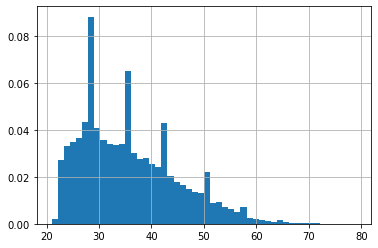

In [17]:
#plot the distribution diagram of df['AGE']
df['AGE'].hist(bins=50, density=True)

In [18]:
print("Mean of AGE: ", df['AGE'].mean())
print("Median of AGE: ", df['AGE'].median())
print("Mode of AGE: ", df['AGE'].mode())

Mean of AGE:  35.738208670795615
Median of AGE:  34.0
Mode of AGE:  0    29.0
dtype: float64


Since the data distribution is skewed, we perform median imputation

In [19]:
AGE_median = X_train['AGE'].median()
X_train['AGE_median'] = X_train['AGE'].fillna(AGE_median)
X_test['AGE_median'] = X_test['AGE'].fillna(AGE_median)

<AxesSubplot:>

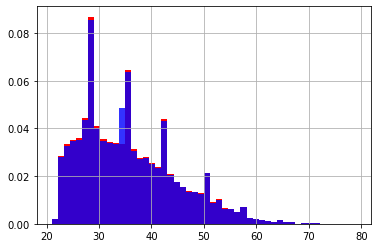

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)
X_train['AGE'].hist(bins=50, ax=ax, density=True, color='red')
X_train['AGE_median'].hist(bins=50, ax=ax, color='blue', density=True, alpha=0.8)

The distribution of the "AGE" column is not distorted by median imputation, as desired. Therefore, we keep the new column 'AGE_median' and drop the old column "AGE".

In [21]:
# dropping the column "AGE" from X_train and X_test
X_train.drop(columns=["AGE"], axis=1, inplace=True)
X_test.drop(columns=["AGE"], axis=1, inplace=True)

### 1.3. Frequent Category Imputation (Mode Imputation)

For the column "EDUCATION", we perform the frequent category imputation.

<AxesSubplot:>

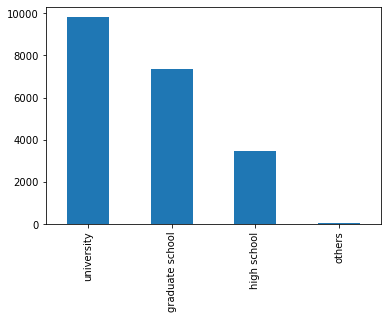

In [22]:
X_train['EDUCATION'].value_counts().sort_values(ascending=False).plot.bar()

In [23]:
EDUCATION_MODE = X_train["EDUCATION"].mode()[0]             
EDUCATION_MODE               

'university'

In [24]:
# implementing the mode imputation for X_train['EDUCATION'] and X_test['EDUCATION']
X_train['EDUCATION'].fillna(EDUCATION_MODE, inplace=True)
X_test['EDUCATION'].fillna(EDUCATION_MODE, inplace=True)

In [25]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((20962, 23), (8984, 23), (20962,), (8984,))

# 2. Categorical encoding

In [26]:
# Recall that we have 3 categorical columns
print(str_cols)

['SEX', 'EDUCATION', 'MARRIAGE']


In [27]:
for col in str_cols:
    print(col, X_train[col].unique())

SEX ['female' 'male']
EDUCATION ['graduate school' 'university' 'high school' 'others']
MARRIAGE ['married' 'single' 'others']


One Hot Encoding (using Scikit-Learn)

In [28]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((20962, 23), (8984, 23), (20962,), (8984,))

In [29]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse= False, handle_unknown='ignore')
encoder.fit(X_train[str_cols])

OneHotEncoder(handle_unknown='ignore', sparse=False)

In [30]:
# transform the categorical columns in X_train
X_train_transformed = encoder.transform(X_train[str_cols])
# turn the transformed Numpy array into a Pandas dataframe
X_train_OHE_skl = pd.DataFrame(X_train_transformed)

In [31]:
X_train_OHE_skl

,0,1,2,3,4,5,6,7,8
0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
20957,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
20958,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
20959,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
20960,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [32]:
# as we can see, the new encoded columns are named as integers. 
# However, the names of the features are stored in the get_feature_names() method
encoder.get_feature_names()

array(['x0_female', 'x0_male', 'x1_graduate school', 'x1_high school',
       'x1_others', 'x1_university', 'x2_married', 'x2_others',
       'x2_single'], dtype=object)

In [33]:
# we now create a dummy_cols_list which contains the names of the categorical columns and their category in the format "col_cat"
dummy_cols_list = list(encoder.get_feature_names())
for i in range(0, len(dummy_cols_list)):
    for j in range(0, len(str_cols)):
        dummy_cols_list[i] = dummy_cols_list[i].replace(f"x{j}_", str_cols[j]+"_") 

In [34]:
# we rename the dataframe columns to the above names
X_train_OHE_skl.columns = dummy_cols_list

In [35]:
X_train_OHE_skl.head()

,SEX_female,SEX_male,EDUCATION_graduate school,EDUCATION_high school,EDUCATION_others,EDUCATION_university,MARRIAGE_married,MARRIAGE_others,MARRIAGE_single
0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [36]:
# transform the catogorical columns in X_test
X_test_transformed = encoder.transform(X_test[str_cols])
# turned the transformed Numpy array into a Pandas dataframe
X_test_OHE_skl = pd.DataFrame(X_test_transformed)
# rename the new encoded  columns 
X_test_OHE_skl.columns = dummy_cols_list

In [37]:
X_train_OHE_skl.shape, X_test_OHE_skl.shape

((20962, 9), (8984, 9))

We now concatenate the original X_train/X_test and the encoded X_train_OHE_skl/X_test_OHE_skl (and then drop the categorical columns from the resulting dataframe). 

In [38]:
X_train = pd.concat([X_train.reset_index(drop=True), X_train_OHE_skl.reset_index(drop=True)], axis=1)
X_train = X_train.drop(columns=str_cols, axis=1)
X_test = pd.concat([X_test.reset_index(drop=True), X_test_OHE_skl.reset_index(drop=True)], axis=1)
X_test = X_test.drop(columns=str_cols, axis=1)

In [39]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((20962, 29), (8984, 29), (20962,), (8984,))

# 3. Handling Outliers
3.1. Identifying the outliers \
3.2. Outlier trimming \
3.3. Outlier Capping


### 3.1. Identifying the outliers

In [40]:
print(num_cols)

['BILL_AMT4', 'PAY_AMT1', 'PAY_5', 'BILL_AMT5', 'BILL_AMT6', 'LIMIT_BAL', 'BILL_AMT2', 'AGE', 'PAY_0', 'BILL_AMT1', 'PAY_AMT4', 'PAY_3', 'PAY_AMT6', 'PAY_6', 'PAY_4', 'PAY_AMT3', 'BILL_AMT3', 'PAY_AMT5', 'PAY_AMT2', 'PAY_2']


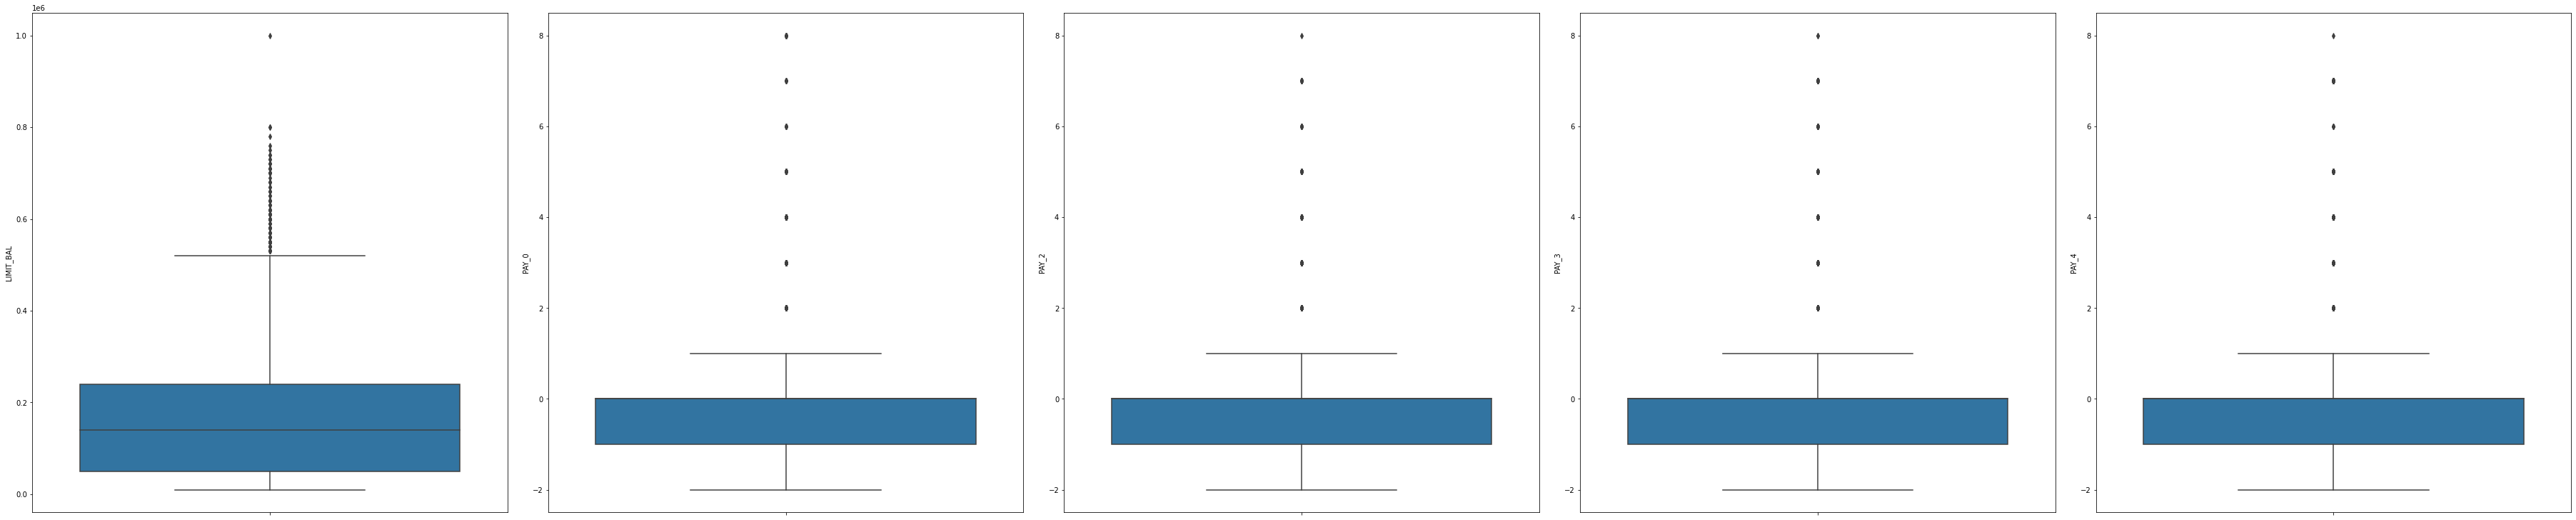

In [41]:
# plot the box-plot of all numerical columns
plt.rcParams["figure.figsize"] = (50,10)
fig, axs = plt.subplots(ncols=5, constrained_layout=True)
sns.boxplot(y=X_train['LIMIT_BAL'], ax=axs[0])
sns.boxplot(y=X_train['PAY_0'], ax=axs[1])
sns.boxplot(y=X_train['PAY_2'], ax=axs[2])
sns.boxplot(y=X_train['PAY_3'], ax=axs[3])
sns.boxplot(y=X_train['PAY_4'], ax=axs[4])
plt.show()


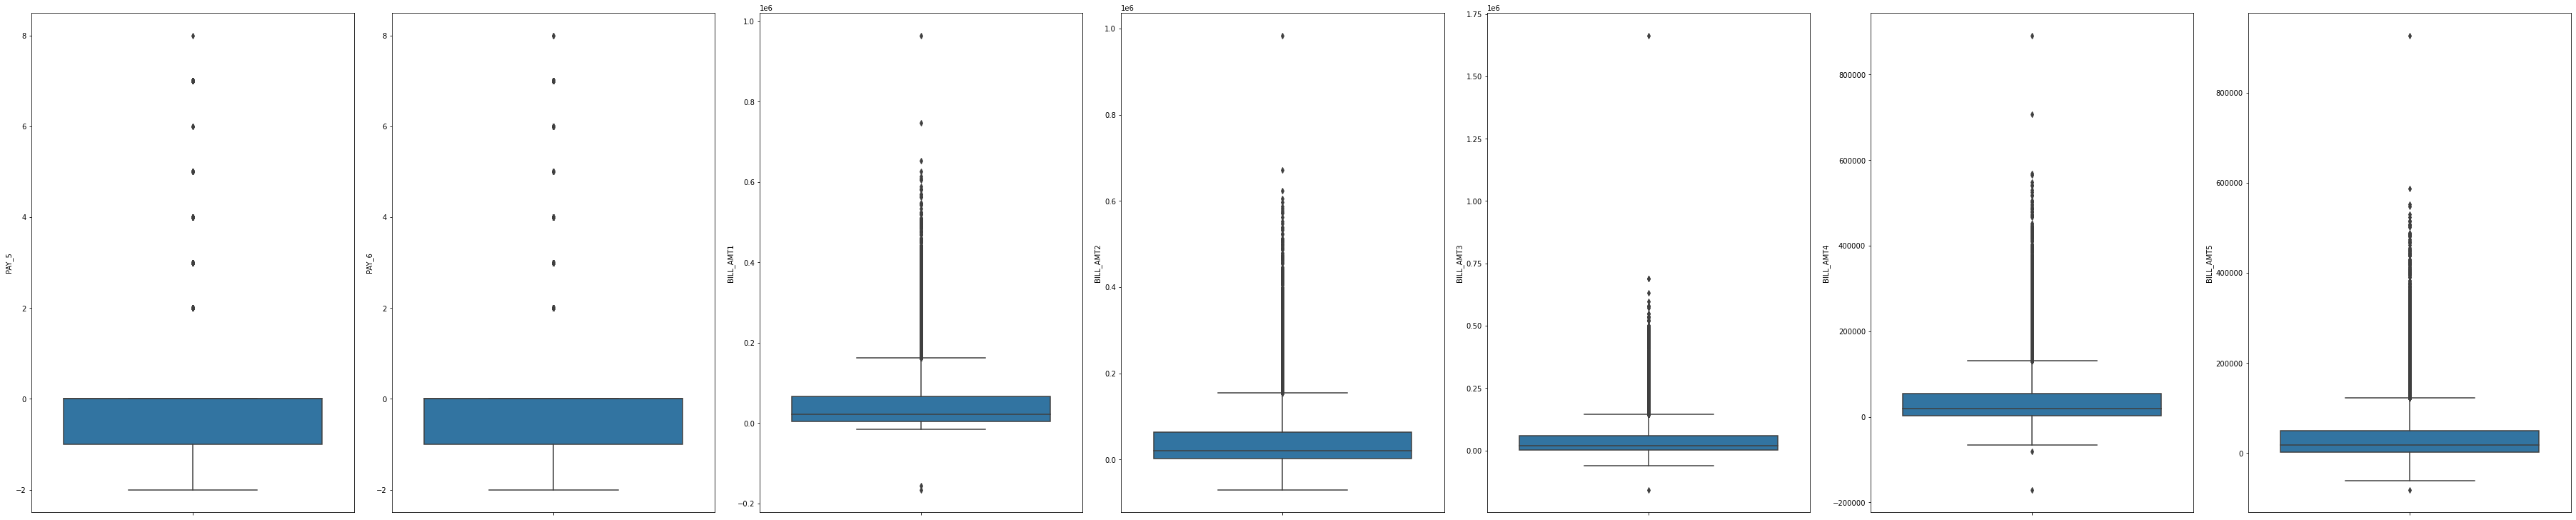

In [42]:
fig, axs = plt.subplots(ncols=7, constrained_layout=True)
sns.boxplot(y=X_train['PAY_5'], ax=axs[0])
sns.boxplot(y=X_train['PAY_6'], ax=axs[1])
sns.boxplot(y=X_train['BILL_AMT1'], ax=axs[2])
sns.boxplot(y=X_train['BILL_AMT2'], ax=axs[3])
sns.boxplot(y=X_train['BILL_AMT3'], ax=axs[4])
sns.boxplot(y=X_train['BILL_AMT4'], ax=axs[5])
sns.boxplot(y=X_train['BILL_AMT5'], ax=axs[6])
plt.rcParams["figure.figsize"] = (50,10)
plt.show()

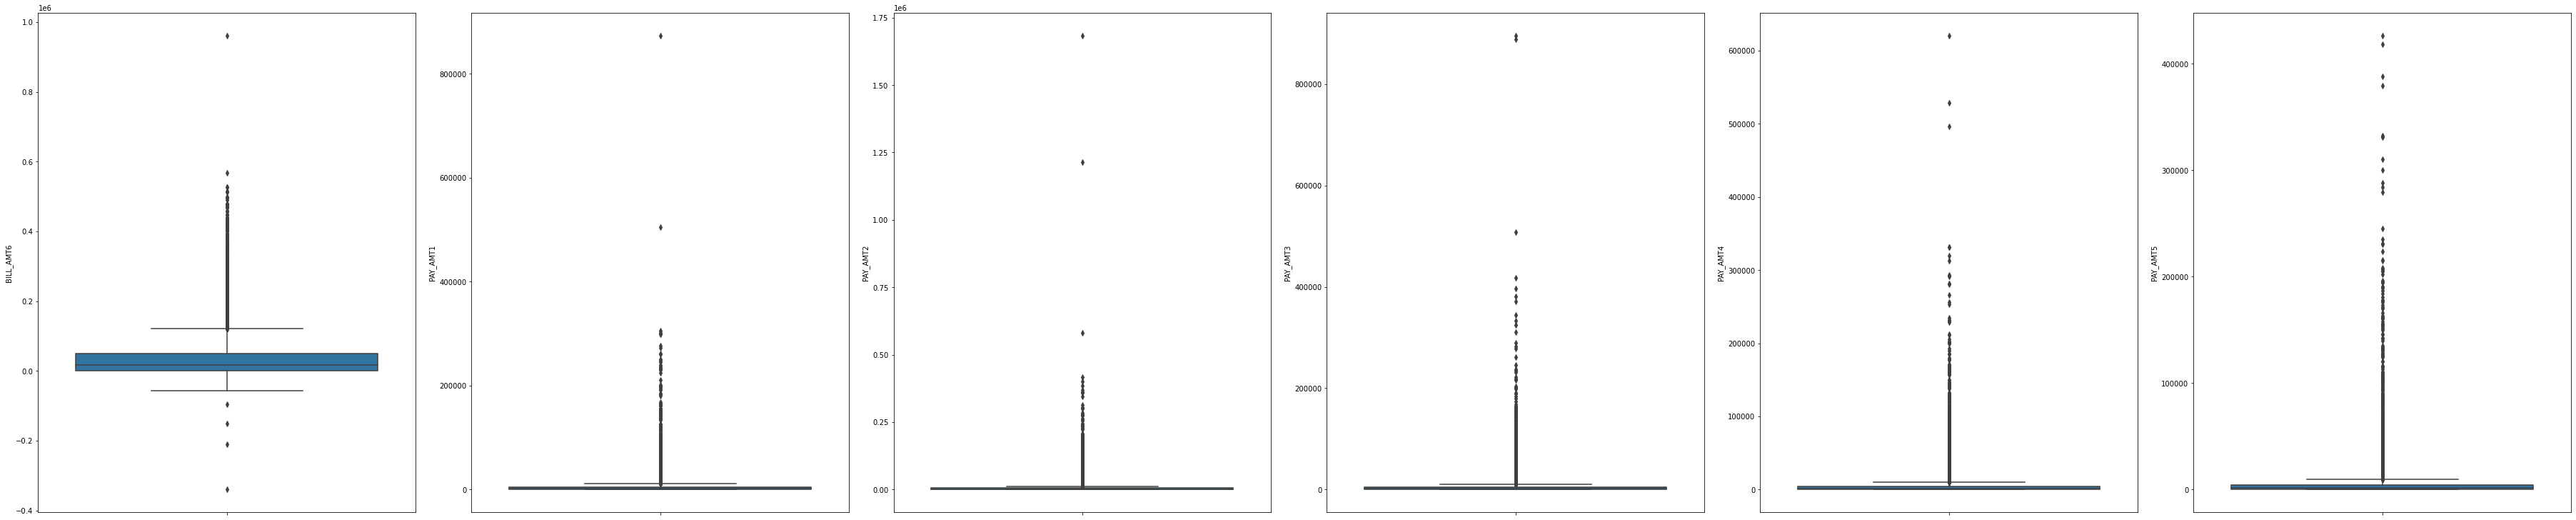

In [43]:
fig, axs = plt.subplots(ncols=6, constrained_layout=True)
sns.boxplot(y=X_train['BILL_AMT6'], ax=axs[0])
sns.boxplot(y=X_train['PAY_AMT1'], ax=axs[1])
sns.boxplot(y=X_train['PAY_AMT2'], ax=axs[2])
sns.boxplot(y=X_train['PAY_AMT3'], ax=axs[3])
sns.boxplot(y=X_train['PAY_AMT4'], ax=axs[4])
sns.boxplot(y=X_train['PAY_AMT5'], ax=axs[5])
plt.rcParams["figure.figsize"] = (50,10)
plt.show()

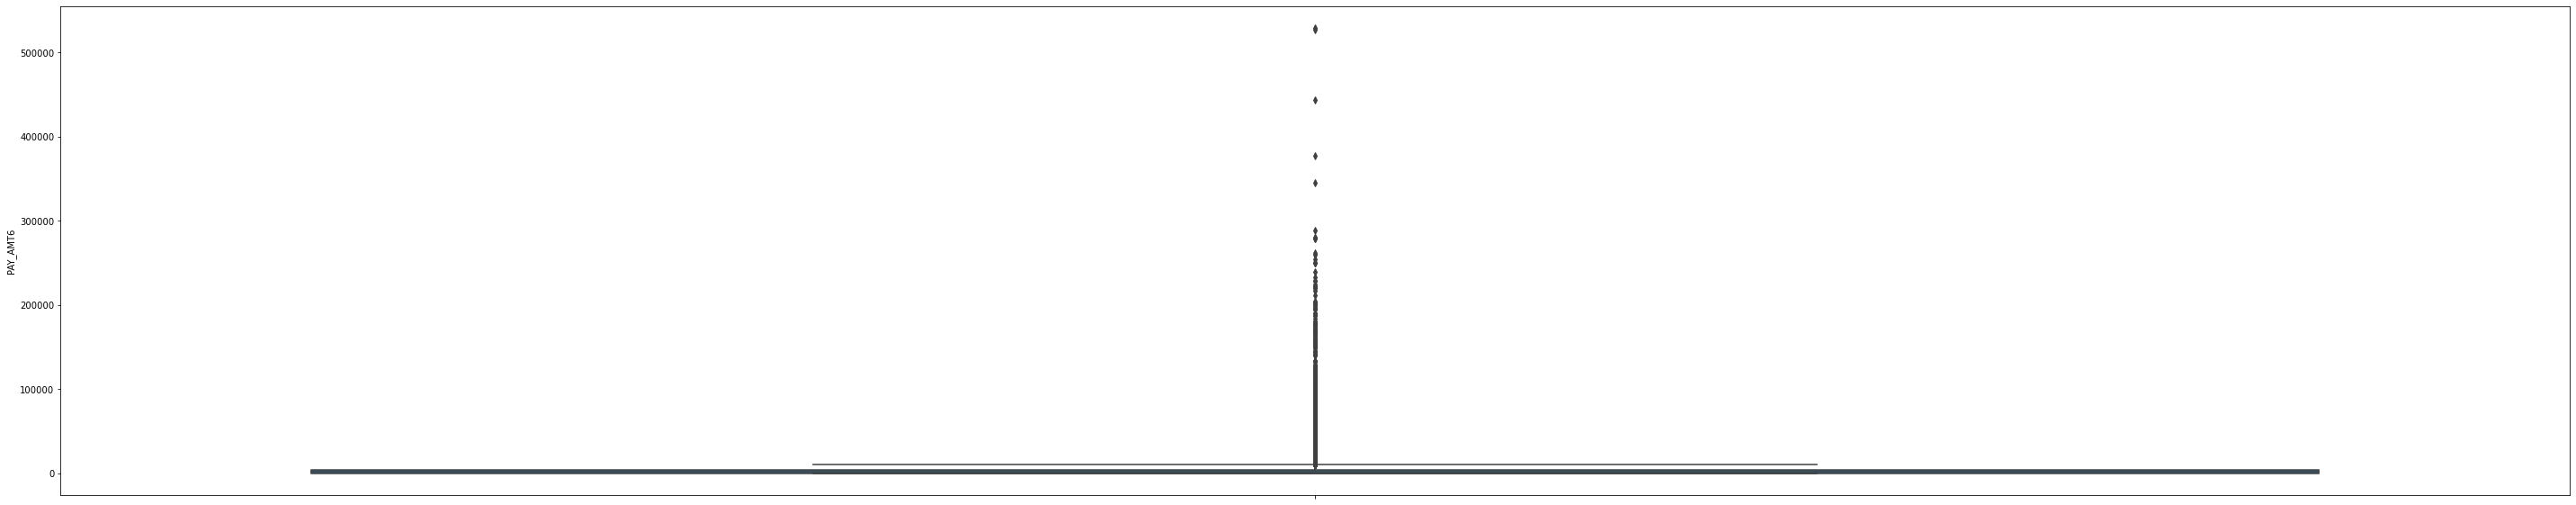

In [44]:
sns.boxplot(y=X_train['PAY_AMT6'])
plt.rcParams["figure.figsize"] = (50,10)
plt.show()

In [45]:
# we now calculate the IRQ, lower_boundary, upper_boundary and outlier_list of all columns.
# We first create the following dictionaries
IRQ_dict= {}
for col in X_train.columns:
    IRQ_dict[f"{col}_IQR"] = X_train[col].quantile(0.75) - X_train[col].quantile(0.25)

lower_boundary_dict= {}
for col in X_train.columns:
    lower_boundary_dict[f"{col}_lower_boundary"] = X_train[col].quantile(0.25) - (IRQ_dict[f"{col}_IQR"] * 1.6)

upper_boundary_dict= {}
for col in X_train.columns:
    upper_boundary_dict[f"{col}_upper_boundary"] = X_train[col].quantile(0.25) + (IRQ_dict[f"{col}_IQR"] * 1.6)

columns_outliers_dict={}
for col in X_train.columns:
    columns_outliers_dict[f"{col}_outliers_list"] = np.where(X_train[col] > upper_boundary_dict[f"{col}_upper_boundary"], True,
                       np.where(X_train[col] < lower_boundary_dict[f"{col}_lower_boundary"], True, False))

In [46]:
outlier_cols = [col for col in X_train.columns if  columns_outliers_dict[f"{col}_outliers_list"].mean() > 0 ] 
print(outlier_cols)

['BILL_AMT4', 'PAY_AMT1', 'PAY_5', 'BILL_AMT5', 'BILL_AMT6', 'LIMIT_BAL', 'BILL_AMT2', 'PAY_0', 'BILL_AMT1', 'PAY_AMT4', 'PAY_3', 'PAY_AMT6', 'PAY_6', 'PAY_4', 'PAY_AMT3', 'BILL_AMT3', 'PAY_AMT5', 'PAY_AMT2', 'PAY_2', 'AGE_median', 'EDUCATION_high school', 'EDUCATION_others', 'MARRIAGE_others']


### 3.2. Outlier trimming
Drop all the records which include an outlier (in X_train)

In [47]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((20962, 29), (20962,), (8984, 29), (8984,))

In [48]:
# we implement the outlier trimming method for outlier_10percent_cols
#create a list of columns with less than 10% outliers
outlier_10percent_cols = [col for col in outlier_cols if columns_outliers_dict[f"{col}_outliers_list"].mean() < 0.1 ] 

print(outlier_10percent_cols)

['EDUCATION_others', 'MARRIAGE_others']


In [49]:
X_train = X_train.loc[~(
+ columns_outliers_dict["MARRIAGE_others_outliers_list"]
+ columns_outliers_dict["EDUCATION_others_outliers_list"]
), 
]

In [50]:
y_train = y_train.loc[~(
+ columns_outliers_dict["MARRIAGE_others_outliers_list"]
+ columns_outliers_dict["EDUCATION_others_outliers_list"]
), 
]

In [51]:
X_train.shape , X_test.shape, y_train.shape, y_test.shape

((20659, 29), (8984, 29), (20659,), (8984,))

The outlier trimming procedure has reduced the 20962 records in X_train/y_train to 20659 records.\
We also need to check if the Imbalance ration is changed.

In [52]:
y_train_class_0 = y_train.value_counts().to_list()[0]
y_train_class_1 = y_train.value_counts().to_list()[1]
print("Imbalance ratio after outlier trimming =", y_train_class_1/y_train_class_0)
print("Original imbalance ratio =", original_imbalance_ratio)

Imbalance ratio after outlier trimming = 0.28404499968922864
Original imbalance ratio = 0.2840267077555213


We observe that the outlier trimming procedure has a very tiny influence on the imbalance ration, which is what we desired.

### 3.3. Outlier Capping

In [53]:
# we create a set of the columns with more than 10 percent outliers
outlier_90percent_cols = list(set(X_train.columns) - set(outlier_10percent_cols)) 

In [54]:
print(outlier_90percent_cols)

['BILL_AMT4', 'PAY_AMT1', 'EDUCATION_graduate school', 'PAY_5', 'MARRIAGE_married', 'BILL_AMT5', 'BILL_AMT6', 'LIMIT_BAL', 'BILL_AMT2', 'PAY_AMT4', 'PAY_0', 'BILL_AMT1', 'SEX_male', 'SEX_female', 'PAY_3', 'PAY_AMT6', 'MARRIAGE_single', 'PAY_6', 'PAY_4', 'PAY_AMT3', 'BILL_AMT3', 'PAY_AMT5', 'AGE_median', 'EDUCATION_university', 'PAY_AMT2', 'PAY_2', 'EDUCATION_high school']


In [55]:
# we implement the outlier capping method for outlier_90percent_cols
for col in outlier_90percent_cols:
    X_train[col] = np.where(X_train[col] > upper_boundary_dict[f"{col}_upper_boundary"], upper_boundary_dict[f"{col}_upper_boundary"],
                         np.where(X_train[col] < lower_boundary_dict[f"{col}_lower_boundary"], lower_boundary_dict[f"{col}_lower_boundary"], X_train[col]))

In [56]:
X_train.shape , X_test.shape, y_train.shape, y_test.shape

((20659, 29), (8984, 29), (20659,), (8984,))

We observe that outlier capping does not reduce the dataset size.

# 4. Feature Scaling

In [57]:
X_train.shape , X_test.shape, y_train.shape, y_test.shape

((20659, 29), (8984, 29), (20659,), (8984,))

### 4.1. Min-Max Scaling

In [58]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Feature Selection
5.1. Dropping Constant Features \
5.2. Correlation-based Feature Selection\
5.2.a Selecting Features with hight correlations with Target\
5.2.b Selecting Features with low correlations with other features

### 5.1. Dropping Constant Features

In [59]:
# creating a list of constant features in X_train
const_feat = [X for X in X_train.columns if X_train[X].nunique() == 1]
const_feat

['EDUCATION_high school', 'EDUCATION_others', 'MARRIAGE_others']

In [60]:
# dropping the constant features from X_train and X_test
X_train.drop(labels=const_feat, axis=1, inplace= True)
X_test.drop(labels=const_feat, axis=1, inplace= True)

In [61]:
X_train.shape , X_test.shape, y_train.shape, y_test.shape

((20659, 26), (8984, 26), (20659,), (8984,))

### 5.2. Correlation-based Feature Selection

### 5.2.a Selecting Features with hight correlations with Target

In [62]:
# We first add the target (y_train) to the Features (X_train) to be able to calculate the correlation matrix between them
df_train = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis = 1)
# create the correlation matrix
cor_mat = df_train.corr()
# Add a column which containes the sorted absolute values of corr(X_train, y_train)
cor_mat["X-Y_corr"]= cor_mat[target].abs().sort_values(ascending=False) 

In [63]:
cor_mat["X-Y_corr"]

BILL_AMT4                     0.012777
PAY_AMT1                      0.144459
PAY_5                         0.116787
BILL_AMT5                     0.010094
BILL_AMT6                     0.002955
LIMIT_BAL                     0.153309
BILL_AMT2                     0.020723
PAY_0                         0.212157
BILL_AMT1                     0.027215
PAY_AMT4                      0.117282
PAY_3                         0.144872
PAY_AMT6                      0.114549
PAY_6                         0.107351
PAY_4                         0.127133
PAY_AMT3                      0.128364
BILL_AMT3                     0.017791
PAY_AMT5                      0.107361
PAY_AMT2                      0.140260
PAY_2                         0.160889
AGE_median                    0.014444
SEX_female                    0.038418
SEX_male                      0.038418
EDUCATION_graduate school     0.056822
EDUCATION_university          0.029344
MARRIAGE_married              0.028145
MARRIAGE_single          

In [64]:
# collect all the features with corr(X_train, y_train) > 0.014 into a list
final_cols = cor_mat[cor_mat["X-Y_corr"] > 0.014].index.values.tolist()
final_cols = list(set(final_cols) - set([target]))

In [65]:
len(final_cols)

23

In [66]:
# replacing the columns in X_train and X_test with final_cols
X_train = X_train[final_cols]
X_test = X_test[final_cols]

In [67]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((20659, 23), (20659,), (8984, 23), (8984,))

### 5.2.b Selecting Features with low correlations with other features

<AxesSubplot:>

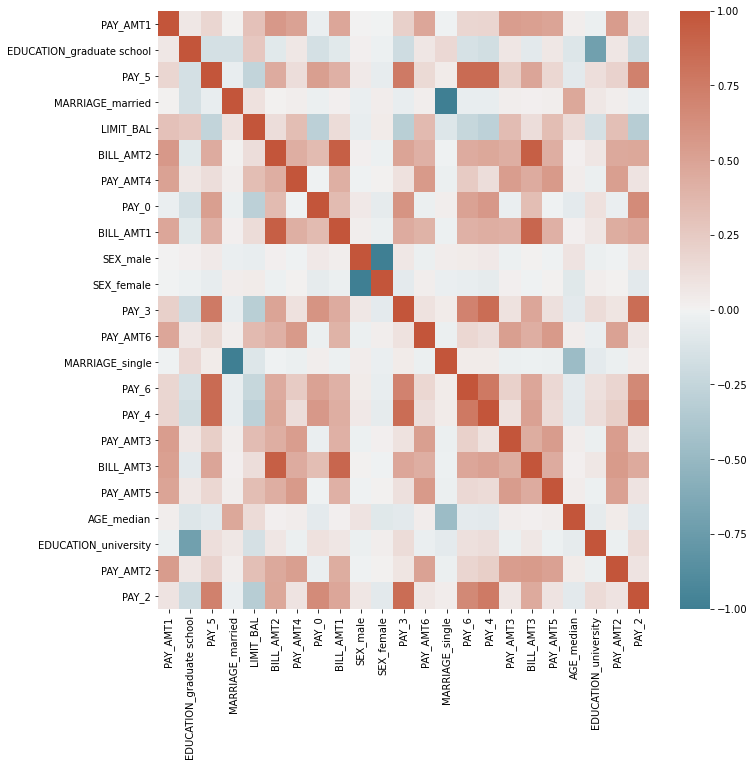

In [68]:
# plotting the correlation diagram of X_train
corrmat = X_train.corr(method='pearson')

cmap = sns.diverging_palette(220, 20, as_cmap=True)

fig, ax = plt.subplots()
fig.set_size_inches(11,11)

sns.heatmap(corrmat, cmap=cmap)

In [69]:
# creating a set of column pairs whose correlation is higher than 88%
col_corr = set()
corr_matrix = X_train.corr()

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.88: 
            print(abs(corr_matrix.iloc[i, j]), corr_matrix.columns[i], corr_matrix.columns[j])
            colname = corr_matrix.columns[j]
            col_corr.add(colname)

0.9368967626998528 BILL_AMT1 BILL_AMT2
1.0 SEX_female SEX_male
0.9999999999999998 MARRIAGE_single MARRIAGE_married
0.9302589812346548 BILL_AMT3 BILL_AMT2
0.8854123841097556 BILL_AMT3 BILL_AMT1


In [70]:
# dropping one of the columns in each pair in col_corr in X_train and X_test
X_train.drop(labels=col_corr, axis=1, inplace=True)
X_test.drop(labels=col_corr, axis=1, inplace=True)

In [71]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((20659, 19), (20659,), (8984, 19), (8984,))

# 6. Finalizing

### 6.1. Saving the preprocessed data

In [72]:
X_train.to_csv("../datasets/classification/processed/X_train.csv", sep = ",", encoding= "utf-8")
X_test.to_csv("../datasets/classification/processed/X_test.csv", sep = ",", encoding= "utf-8")
y_train.to_csv("../datasets/classification/processed/y_train.csv", sep = ",", encoding= "utf-8")
y_test.to_csv("../datasets/classification/processed/y_test.csv", sep = ",", encoding= "utf-8")

### 6.2. Testing the cleaned data with feeding it to a logistic regression algorithm

In [73]:
from sklearn.linear_model import LogisticRegression 
classifier = LogisticRegression() 
classifier.fit(X = X_train, y = y_train)

LogisticRegression()

In [74]:
train_score = classifier.score(X_train, y_train)
print("The training score of model is: ", train_score)
test_score = classifier.score(X_test, y_test)
print("The score of the model on test data is:", test_score )

The training score of model is:  0.7785468802943027
The score of the model on test data is: 0.7779385574354408
